In [1]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import altair
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
def matrix_construct_adjust(seq, contain_mid=True, oneside_num=30):
    if contain_mid:
        if len(seq) != oneside_num * 2 + 3:
            raise Exception('seq len is wrong!')
    elif contain_mid == False:
        if len(seq) != oneside_num * 2:
            raise Exception('seq len is wrong!')

    if contain_mid:
        seq = seq[0:oneside_num] + seq[oneside_num + 3: oneside_num * 2 + 3]
    
    seq_matrix = np.zeros((oneside_num * 2,4))
    i = 0

    for nc in seq:
        if nc == 'A':
            nc = 0
        elif nc == 'T':
            nc = 1
        elif nc == 'C':
            nc = 2
        elif nc == 'G':
            nc = 3
        
        seq_matrix[i,nc] = 1
        i = i + 1
    
    return(seq_matrix)

def score_cal_adjust(seq_matrix, weights_matrix,oneside_num=30):
    weights_matrix = weights_matrix[30 - oneside_num : oneside_num + 30]
    result_matrix = weights_matrix * seq_matrix
    result = (np.sum(result_matrix) - np.sum(np.min(weights_matrix,axis=1))) / (np.sum(np.max(weights_matrix,axis=1)) - np.sum(np.min(weights_matrix,axis=1)))
    #result = np.sum(result_matrix) 
    return(result)

def matrix_construct_adjust_l(seq, contain_mid=True, oneside_num=30):
    seq_matrix = np.zeros((oneside_num,4))
    i = 0

    for nc in seq:
        if nc == 'A':
            nc = 0
        elif nc == 'T':
            nc = 1
        elif nc == 'C':
            nc = 2
        elif nc == 'G':
            nc = 3
        
        seq_matrix[i,nc] = 1
        i = i + 1
    
    return(seq_matrix)

def score_cal_adjust_l(seq_matrix, weights_matrix,oneside_num=30):
    weights_matrix = weights_matrix[30 - oneside_num : 30]
    result_matrix = weights_matrix * seq_matrix
    result = (np.sum(result_matrix) - np.sum(np.min(weights_matrix,axis=1))) / (np.sum(np.max(weights_matrix,axis=1)) - np.sum(np.min(weights_matrix,axis=1)))
    #result = np.sum(result_matrix) 
    return(result)

In [3]:
#data training

In [4]:
weights = np.loadtxt('weights_kpLogo_rank.txt')

In [5]:
seq_eff = pd.read_excel('TCG scores validate(ub_seq_EGFP)-3-2-final.xlsx')

In [6]:
def score_cal_adjust_array(seq_matrix, weights_matrix=weights,oneside_num=30):
    weights_matrix = weights_matrix[30 - oneside_num : oneside_num + 30]
    result_matrix = weights_matrix * seq_matrix
    #result = (np.sum(result_matrix) - np.sum(np.min(weights_matrix,axis=1))) / (np.sum(np.max(weights_matrix,axis=1)) - np.sum(np.min(weights_matrix,axis=1)))
    result = np.sum(result_matrix,axis=1) 
    return(result)

In [7]:
n = 6
score_list = []
for index,row in seq_eff.iterrows():
    score1 = score_cal_adjust_array(matrix_construct_adjust(row.seq_w_TCG[12 - n : 15 + n],oneside_num=n),weights,oneside_num=n)
    score_list.append(score1)

X2 = pd.DataFrame(score_list)
y2 = seq_eff.ratio

In [8]:
from sklearn.linear_model import Ridge

0.7069440176126348


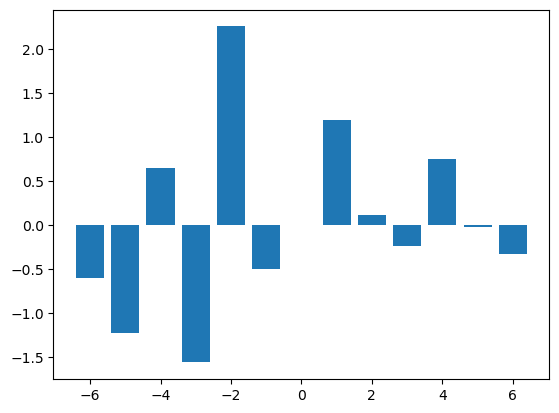

In [9]:
ridge = Ridge(alpha=200).fit(X2,y2)
plt.bar(x=[-6,-5,-4,-3,-2,-1,1,2,3,4,5,6],height=ridge.coef_.T)
print(np.corrcoef(y2,ridge.predict(X2))[0,1])

In [10]:
temp_array = np.zeros((60,1))
temp_array[24:36,:] = ridge.coef_[:,np.newaxis]
weights_new = weights * temp_array

In [11]:
#np.savetxt('weights_ml_20230613.txt',weights_new)

In [12]:
#data plot

In [14]:
weights_new = np.loadtxt('weights_ml_20230613.txt')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_37488\2689290608.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weights_l = weights_l.loc[0:29,].append(tcg).append(weights_l.loc[30:,]).reset_index(drop=True)


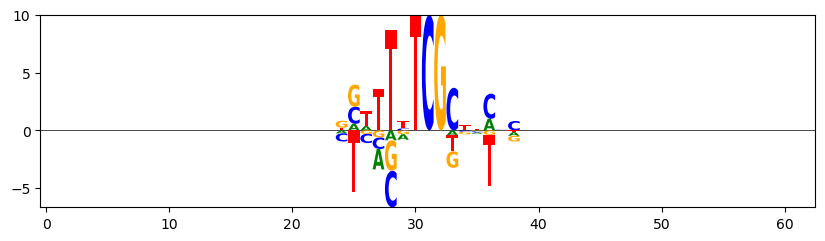

In [15]:
import logomaker
#ATCG
weights_l = pd.DataFrame(weights_new)
weights_l.columns = ['A','T','C','G']
tcg = pd.DataFrame([[0,10,0,0],[0,0,10,0],[0,0,0,10]])
tcg.columns = ['A','T','C','G']
weights_l = weights_l.loc[0:29,].append(tcg).append(weights_l.loc[30:,]).reset_index(drop=True)
p = logomaker.Logo(weights_l,flip_below=False)
#plt.savefig('logo_rank_ml.pdf')

In [16]:
n = 6
for index,row in seq_eff.iterrows():
    score1 = score_cal_adjust(matrix_construct_adjust(row.seq_w_TCG[12 - n : 15 + n],oneside_num=n),weights_new,oneside_num=n)
    seq_eff.loc[index,'score_adjust'] = score1

plt.figure(figsize=(6,6))
#plt.scatter(x = seq_eff.ratio, y = seq_eff.score_adjust, marker='o')
#plt.scatter(x = oneside_list, y = pearson_list_10, marker='s')
#plt.show()
y = seq_eff.ratio
x = seq_eff.score_adjust
para = np.polyfit(x,y,1)
y2 = para[0] * x + para[1]

#y_err = x.std() * np.sqrt(1 + 1/len(x) + ((x - x.mean())**2 / np.sum((x - x.mean())**2)))
y_err = y2.std() * np.sqrt(1 + 1/len(y2) + ((y2 - y2.mean())**2 / np.sum((y2 - y2.mean())**2)))


<Figure size 600x600 with 0 Axes>

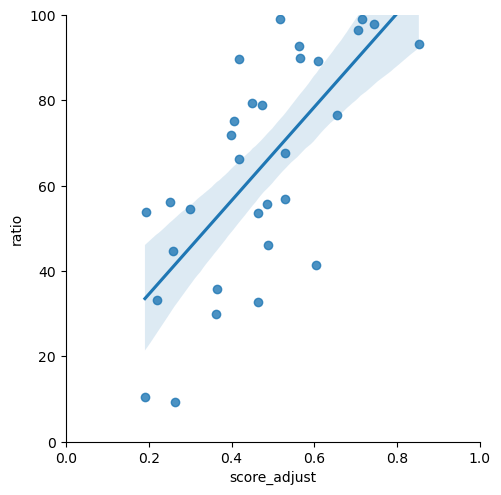

In [17]:
p = sns.lmplot(x='score_adjust',y='ratio',data=seq_eff)
p.set(xlim=(0,1), ylim=(0,100))
#p.figure.savefig("out.svg")
#seq_eff.to_excel('validate_data/TCG scores validate(ub_seq_EGFP)-1-1-2.xlsx')

In [18]:
scipy.stats.linregress(x, y)

LinregressResult(slope=109.78528880397678, intercept=12.564961598316735, rvalue=0.7069440176126346, pvalue=8.759509561800414e-06, stderr=20.396002694719854, intercept_stderr=10.095764309089036)

In [19]:
seq_eff2 = pd.read_excel('test_data_final_2.xlsx')

LinregressResult(slope=0.5092553519631411, intercept=0.3838558515827214, rvalue=0.6243879477764794, pvalue=0.02998461496797928, stderr=0.20146320055800374, intercept_stderr=0.06578393078933234)

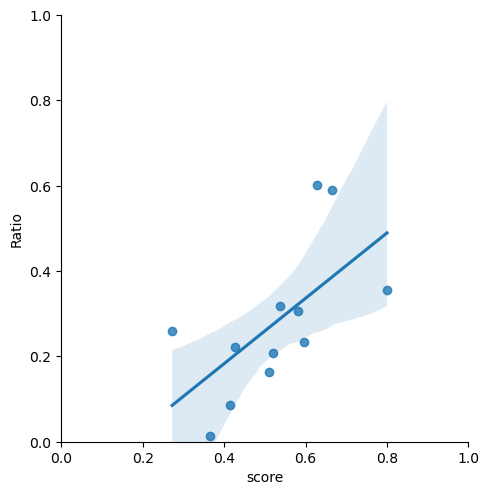

In [20]:
n = 6
for index,row in seq_eff2.iterrows():
    seq_eff2.loc[index,'score'] = score_cal_adjust(matrix_construct_adjust(row.Seq,oneside_num=n),weights_new,oneside_num=n)

seq_eff3 = seq_eff2.loc[seq_eff2.Condition == 'YW-2',]
x = seq_eff3.Ratio
y = seq_eff3.score
para = np.polyfit(x,y,1)
y2 = para[0] * x + para[1]

p = sns.lmplot(x='score',y='Ratio',data=seq_eff3)
p.set(xlim=(0,1), ylim=(0,1))
#p.figure.savefig("yw2.svg")
scipy.stats.linregress(x, y)

LinregressResult(slope=0.6471187750299339, intercept=0.1770321239244208, rvalue=0.7655784979176011, pvalue=0.0003409436749312284, stderr=0.14040768575704343, intercept_stderr=0.06263222515325402)

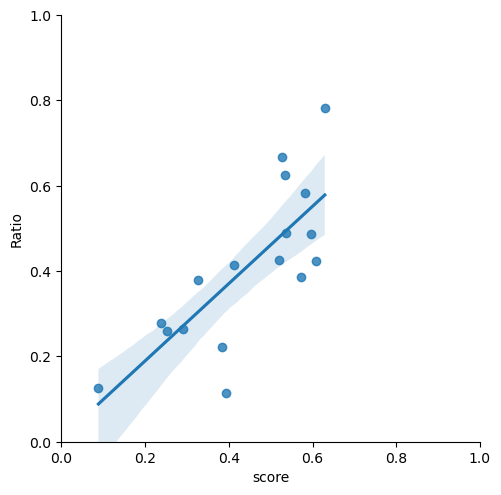

In [21]:
n = 6
for index,row in seq_eff2.iterrows():
    seq_eff2.loc[index,'score'] = score_cal_adjust(matrix_construct_adjust(row.Seq,oneside_num=n),weights_new,oneside_num=n)

seq_eff3 = seq_eff2.loc[seq_eff2.Condition == 'YW-7',]
x = seq_eff3.Ratio
y = seq_eff3.score
para = np.polyfit(x,y,1)
y2 = para[0] * x + para[1]

p = sns.lmplot(x='score',y='Ratio',data=seq_eff3)
p.set(xlim=(0,1), ylim=(0,1))
#p.figure.savefig("yw7.svg")
scipy.stats.linregress(x, y)

In [ ]:
#seq_eff2.to_excel('test_data_final_2.xlsx')